In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from crninf.algorithm import get_skeletons, Reactmine
from crninf.evaluate import predict
from crninf.utils import low_complexity_crn, print_crn, set_matplotlib_params
from toy_crns import func_crn_name # necessitates to load the notebook from the examples directory

import pysindy as ps

from matplotlib.lines import Line2D

In [2]:
set_matplotlib_params()

## Reproducing Table 1 from main text

This section shows how to reproduce the results depicted in Table 1 from the main text. The hyperparameters used for Reactmine are obtained through gridsearch, the latter not being shown here as the process takes several hours per CRN. See Figure S11 for gridsearch results. We pick the parameter set that leads to shortest compute time.

In [3]:
crns = ["reactant_parallel", "product_parallel", "chain", "loop", "mapk"]
a, d = .02, 3 # alpha and delta_max are similar across examples
hypers = [[a, d, 5, 4], [a, d, 3, 5], [a, d, 4, 7], [a, d, 6, 7], [a, d, 10, 6]] # alpha, delta_max, gamma, beta
lambdas = [0.24, 0.34, 0.2, 0.22, 7.3e-6]
for c in range(len(crns)):
    print(f"\n--------------{crns[c]}--------------\n")
    if crns[c] != "mapk":
        T, npts = 10, 101
    else:
        T, npts = 100, 301
    dt = T / npts
    t = np.linspace(0, T, npts)
    gt_crn, K, cata, name_species, y0, ode = func_crn_name(crns[c])()
    exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))

    params = hypers[c]

    algo = Reactmine(
        [exps],
        v=None,
        t=[t],
        species_names=name_species,
        alpha=params[0],
        delta_max=params[1],
        gamma=params[2],
        beta=params[3],
        verbose=0,
    )

    tree, crnlist, energies = algo.fit()
    bestcrn, idx_comp = low_complexity_crn(crnlist, energies)

    # print crn with zero-valued reactions
    print_crn(crnlist[idx_comp], name_species)
    print("\nkinetics before global re-optimization:\n")
    print([float(crnlist[idx_comp][f"reaction {i}"]["old_kinetics"]) for i in range(len(crnlist[idx_comp]))])

    print('\nSINDy results\n')

    poly_library = ps.PolynomialLibrary(
    degree=2, include_bias=True, interaction_only=True
)

    optimizer = ps.STLSQ(threshold=lambdas[c], max_iter=20000, normalize_columns=False)

    model = ps.SINDy(
        feature_library=poly_library,
        optimizer=optimizer,
        feature_names=name_species,
    )

    model.fit(
        algo.y,
        x_dot=algo.vinit,
        t=t,
    )
    model.print()


--------------reactant_parallel--------------

MA(2.00109) for C -> D
MA(0.0) for E -> ∅
MA(1.00101) for E -> D
MA(0.0) for ∅ -> D + E with catalyst B
MA(2.9438) for A -> B with catalyst D

kinetics before global re-optimization:

[1.9769851686249558, 0.9964044880990872, 0.005263000105321458, 4.4997741686356045e-05, 2.9579058188090244]

SINDy results

(A)' = -1.116 A + -510000276790.315 D + -0.871 A B + 1.034 A C + 510000276788.570 A D + 510000276790.315 B D + -0.039 C D
(B)' = 1.116 A + 510000276790.235 D + 0.871 A B + -1.035 A C + -510000276788.490 A D + -510000276790.235 B D + 0.039 C D
(C)' = -2.201 C + 0.019 E + -0.192 A C + 0.395 C E
(D)' = 0.073 A + 1.955 C + 1.015 E + -0.063 C E
(E)' = -1.001 E

--------------product_parallel--------------

MA(2.93603) for C -> E
MA(1.95736) for C -> D
MA(0.96373) for A -> B with catalyst C

kinetics before global re-optimization:

[3.1265723538616035, 2.0843816699991433, 1.0400252908018122]

SINDy results

(A)' = -0.933 C
(B)' = 0.933 C
(C)' 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


MA(0.00449) for A -> Ap
MA(499.96702) for Bp -> Bpp with catalyst Ap
MA(500.01476) for B -> ∅ with catalyst Ap
MA(150.0422) for ApB -> Ap + Bp
MA(501.19113) for Ap + B -> ApB
MA(150.37065) for ApB -> Ap + B
MA(0.0) for ∅ -> ApB with catalyst Bp
MA(517.78303) for Ap + Bp -> ApBp
MA(155.33508) for ApBp -> Ap + Bp
MA(500.18845) for Ap -> ApB with catalyst B

kinetics before global re-optimization:

[0.004500001574915726, 499.967024778436, 500.0147612826286, 150.03923161160702, 501.19119387011483, 150.36767580570702, 0.06015433594396051, 517.7858199182391, 155.32578122590834, 500.1885125123365]

SINDy results

(Bpp)' = 11764.888 1 + -9818.814 Bpp + -21809.207 Ap + -64774.817 ApBp + -9881.632 Bp + 109653.062 ApB + -10102.573 B + -23028.829 A + 23087.898 Bpp Ap + 47383.244 Bpp ApBp + 0.007 Bpp Bp + -94598.543 Bpp ApB + 0.052 Bpp B + 24104.250 Bpp A + 58119.140 Ap Bp + 117674.075 Ap B + 68314.424 ApBp Bp + 239788.361 ApBp B + -171491.969 Bp ApB + 0.031 Bp B + 45027.819 Bp A + 118690.335 B A
(

## Lack of generalization of SINDy's learned models.

In this section, we show briefly that the ODE models inferred by SINDy and displayed in the article do not generalize well. We first detail our strategy to select the hyperparameter $\lambda$ and show that the learned models do not succeed to reproduce simulations under unseen initial conditions for the chain, loop and parallel CRN.

In [4]:
plt.rcParams.update({
                    "axes.spines.right": True,
                    "axes.spines.top": True
                    })

crns =  ["chain", "loop"]
results = np.zeros([len(crns), 2, 2001])
L = [np.logspace(-3, .1, 2001)]*len(crns)

In [5]:
for ic, c in enumerate(crns):
    print(c)
    gt_crn, K, cata, name_species, y0, ode = func_crn_name(c)()
    T, npts = 10, 101
    t = np.linspace(0, T, npts)
    exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))
    # reactmine instantiation just needed to compute the derivatives
    algo = Reactmine(y=[exps], t=[t], v=None,
                    species_names=name_species, verbose=True,
                    alpha=.0025, beta=7, gamma=6, delta_max=3, delta_step=0.1)

    poly_library = ps.PolynomialLibrary(
        degree=2, include_bias=True, interaction_only=True
    )
    for il, l in enumerate(L[ic]):
        optimizer = ps.STLSQ(threshold=l, max_iter=20000, normalize_columns=False)

        model = ps.SINDy(
            feature_library=poly_library,
            optimizer=optimizer,
            feature_names=name_species,
        )

        model.fit(
            algo.y,
            x_dot=algo.vinit,
            t=t,
        )
        system = np.sign(model.coefficients()).ravel()
        results[ic, 0, il] = np.sum(((model.predict(algo.y) - algo.vinit) / np.abs(algo.vinit).max(axis=0)) ** 2) / len(t)
        results[ic, 1, il] = model.complexity

chain
loop


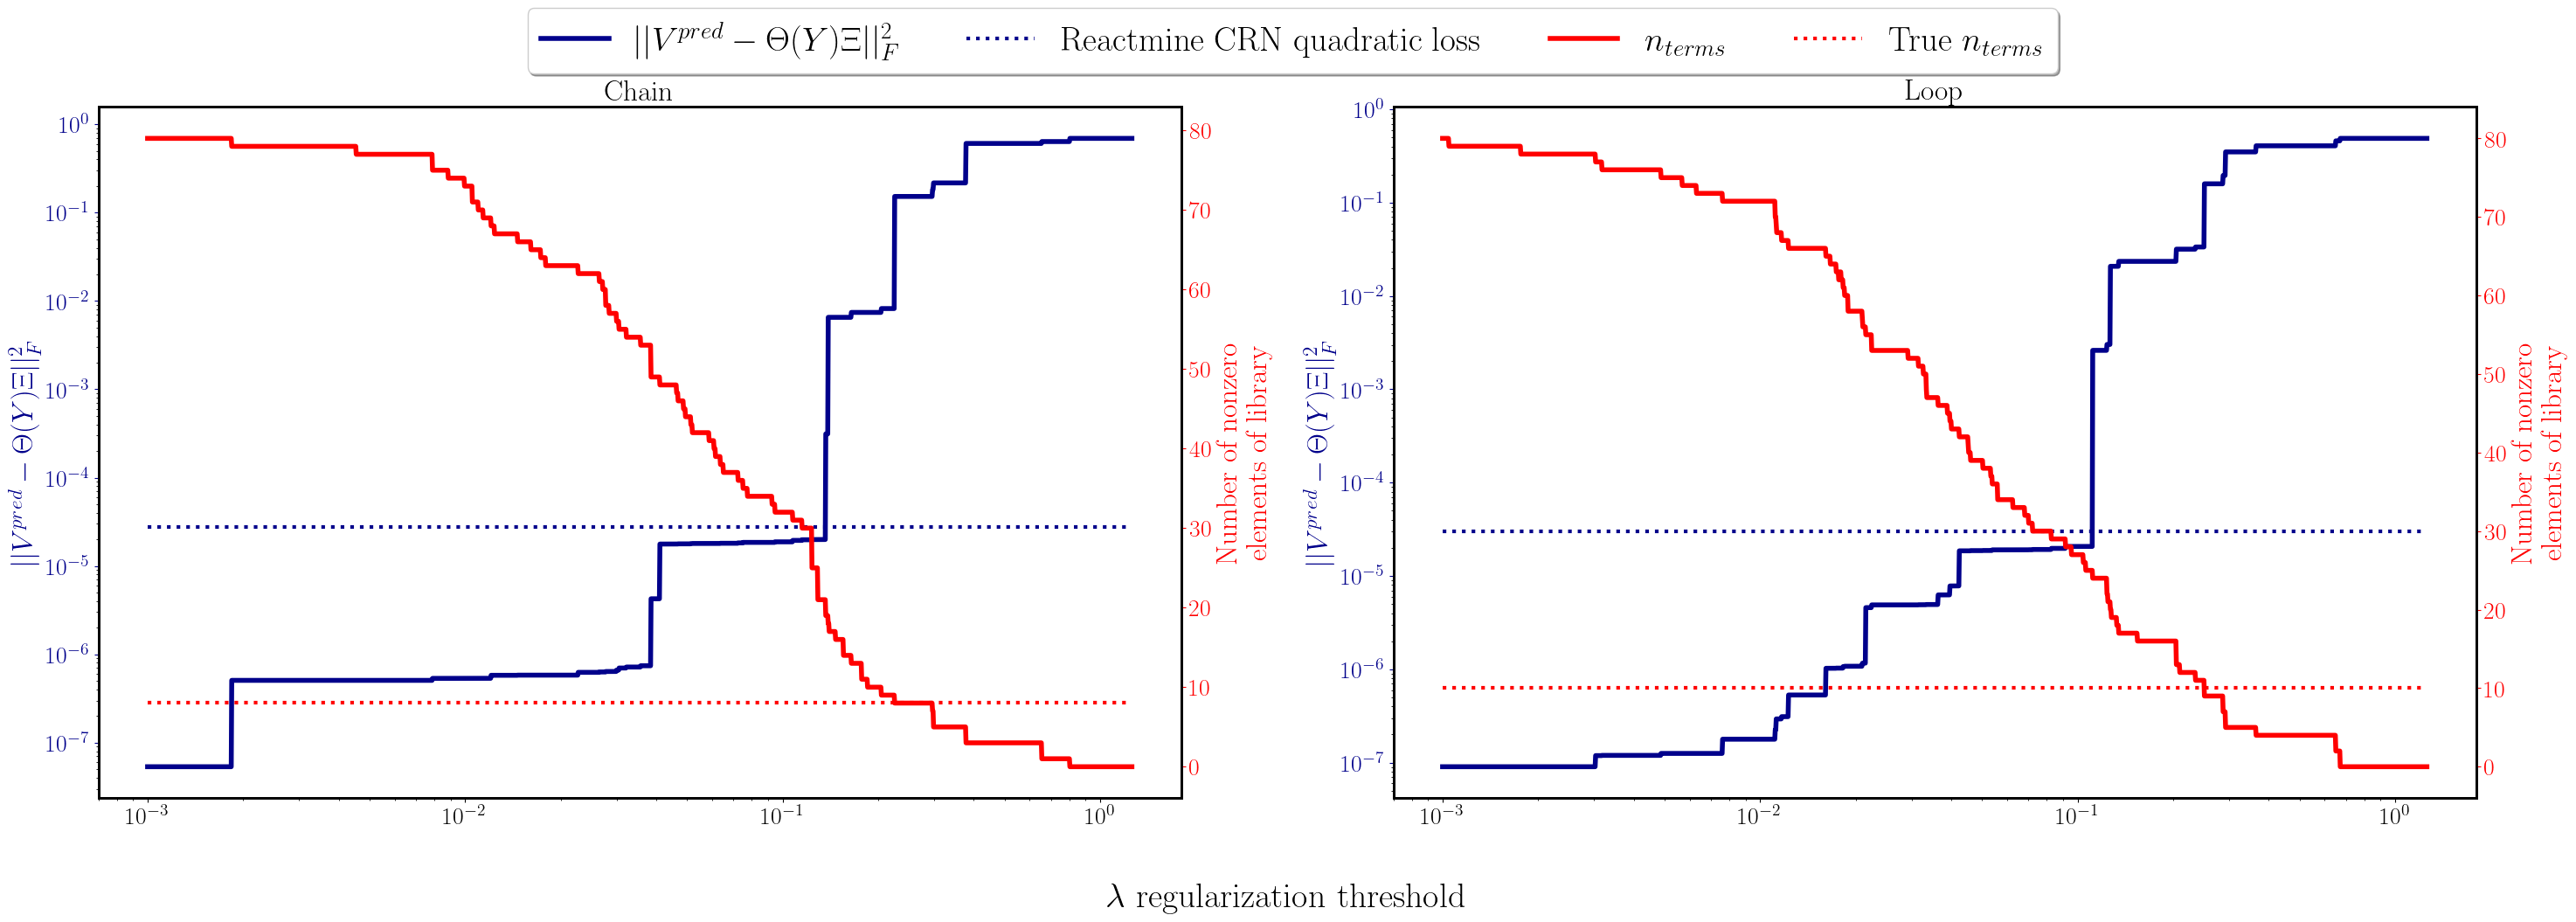

In [6]:
opt = [8, 10]
optval = [2.76e-05, 3e-05] # quadratic loss value found by Reactmine
fig, axes = plt.subplots(1,2,figsize=(30, 10))
for i, ax in enumerate(axes.flat):
    ax.plot(L[i], results[i, 0], label='$||V^{pred}-\Theta(Y)\Xi||_F^2$' if not i else None, linewidth=4, color='darkblue')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ymin, ymax = ax.get_ylim()
    ax2 = ax.twinx()
    ax2.plot(L[i], results[i, 1], color='red', label='$n_{terms}$' if not i else None, linewidth=4)
    ax2.hlines(opt[i], L[i].min(), L[i].max(), color='red', linestyle='dotted', label='True $n_{terms}$' if not i else None, linewidth=3)
    ax.set_title(crns[i].capitalize() if crns[i] != "lv" else "Lokta Volterra")
    ax.set_ylabel('$||V^{pred}-\Theta(Y)\Xi||_F^2$')
    ax2.set_ylabel('Number of nonzero\nelements of library')
    ax.hlines(optval[i], L[i].min(), L[i].max(), color='darkblue', linestyle='dotted', label='Reactmine CRN quadratic loss' if not i else None, linewidth=3)
    ax.yaxis.label.set_color('darkblue')
    ax2.yaxis.label.set_color('red')
    ax.tick_params(axis='y', colors='darkblue')
    ax2.tick_params(axis='y', colors='red')
fig.supxlabel('$\lambda$ regularization threshold')
fig.legend(ncol=4,bbox_to_anchor=(.8, 1.065), fontsize=28, shadow=True)
fig.tight_layout()
plt.show()

There is hardly a proper cutoff value. In particular, Sindy never finds the ground truth model for any $\lambda$. This can be seen for the fact that when the dashed black line crosses the red line, the corresponding optimization error level (darkblue) is too high (between $10^{-1}$ and $10^{-2}$ for the 2 examples).
For each CRN, we therefore compute the $\lambda$ value leading to a model with same quadratic loss as the ones found by Reactmine

In [7]:
idx = [np.searchsorted(results[i, 0, :], optval[i]) for i in range(len(crns))]
[f"{crns[i]}: {L[i][idx[i]]}" for i in range(len(crns))]

['chain: 0.1367413930650353', 'loop: 0.1115706594425556']

In [8]:
lambs_old = [L[i][idx[i]] for i in range(len(crns))]
for ic, c in enumerate(crns):
    gt_crn, K, cata, name_species, y0, ode = func_crn_name(c)()
    exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))
    algo = Reactmine(y=[exps], t=[t], v=None,
                    species_names=name_species, verbose=True,
                    alpha=.0025, beta=7, gamma=6, delta_max=3, delta_step=0.1)

    poly_library = ps.PolynomialLibrary(
        degree=2, include_bias=True, interaction_only=True
    )

    optimizer = ps.STLSQ(threshold=lambs_old[ic], max_iter=20000, normalize_columns=False)

    model = ps.SINDy(
        feature_library=poly_library,
        optimizer=optimizer,
        feature_names=name_species,
    )

    model.fit(
        algo.y,
        x_dot=algo.vinit,
        t=t,
    )
    print(c, lambs_old[ic])
    model.print()
    print('\n')

chain 0.1367413930650353
(A)' = -1.001 A
(B)' = 0.993 A + -1.130 B + 0.044 C + 0.228 A B + -0.096 A C + 0.274 B C
(C)' = 1.034 B + -1.033 C + 0.012 D + -0.055 A B
(D)' = 0.131 B + 1.047 B C + -0.132 C E + -0.548 D E
(E)' = 0.003 C + 0.992 D + 0.007 C E + 0.004 D E


loop 0.1115706594425556
(A)' = -1.000 A + -0.006 D + 1.031 E + -0.067 A E + -0.056 D E
(B)' = 0.994 A + -0.938 B + 0.004 C + 0.001 A B + -0.211 A C + -0.092 B C
(C)' = 1.142 B + -1.183 C + -0.002 D + -0.171 A B + 0.386 C D
(D)' = 0.002 B + 0.989 C + -0.985 D + -0.006 E + 0.005 B C
(E)' = 0.389 C + 0.457 E + -4.209 A E




We see that some terms are almost zeros (e.g. $\dot{D}$ in the loop CRN), a manual search for a $\lambda$ yielding more parsimonious models leads to the values

In [9]:
lambs = [0.2,0.22]

For which we can run SINDy again

In [10]:
models = []
for ic, c in enumerate(crns):
    gt_crn, K, cata, name_species, y0, ode = func_crn_name(c)()
    exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))
    algo = Reactmine(y=[exps], t=[t], v=None,
                    species_names=name_species, verbose=True,
                    alpha=.0025, beta=7, gamma=6, delta_max=3, delta_step=0.1)

    poly_library = ps.PolynomialLibrary(
        degree=2, include_bias=True, interaction_only=True
    )

    optimizer = ps.STLSQ(threshold=lambs[ic], max_iter=20000, normalize_columns=False)

    model = ps.SINDy(
        feature_library=poly_library,
        optimizer=optimizer,
        feature_names=name_species,
    )

    model.fit(
        algo.y,
        x_dot=algo.vinit,
        t=t,
    )
    print(c, lambs[ic], np.sum(((model.predict(algo.y) - algo.vinit) / np.abs(algo.vinit).max(axis=0)) ** 2) / len(t))
    model.print()
    print('\n')
    models.append(model)

chain 0.2 0.007418049515859646
(A)' = -1.001 A
(B)' = 1.000 A + -0.997 B
(C)' = 1.034 B + -1.033 C + 0.012 D + -0.055 A B
(D)' = 0.333 B + -0.642 D E
(E)' = 1.000 D


loop 0.22 0.03173161185602494
(A)' = -1.001 A + 1.001 E
(B)' = 1.000 A + -0.999 B
(C)' = 1.020 B + -1.013 C + 0.001 D + -0.040 A B
(D)' = 0.350 B + -0.351 E
(E)' = 0.421 C + -0.391 E




Although these models yield low training error, their performances do not generalize to unseen data. To see this, let us perform numerical integration of the learned models using new initial conditions $y_0$

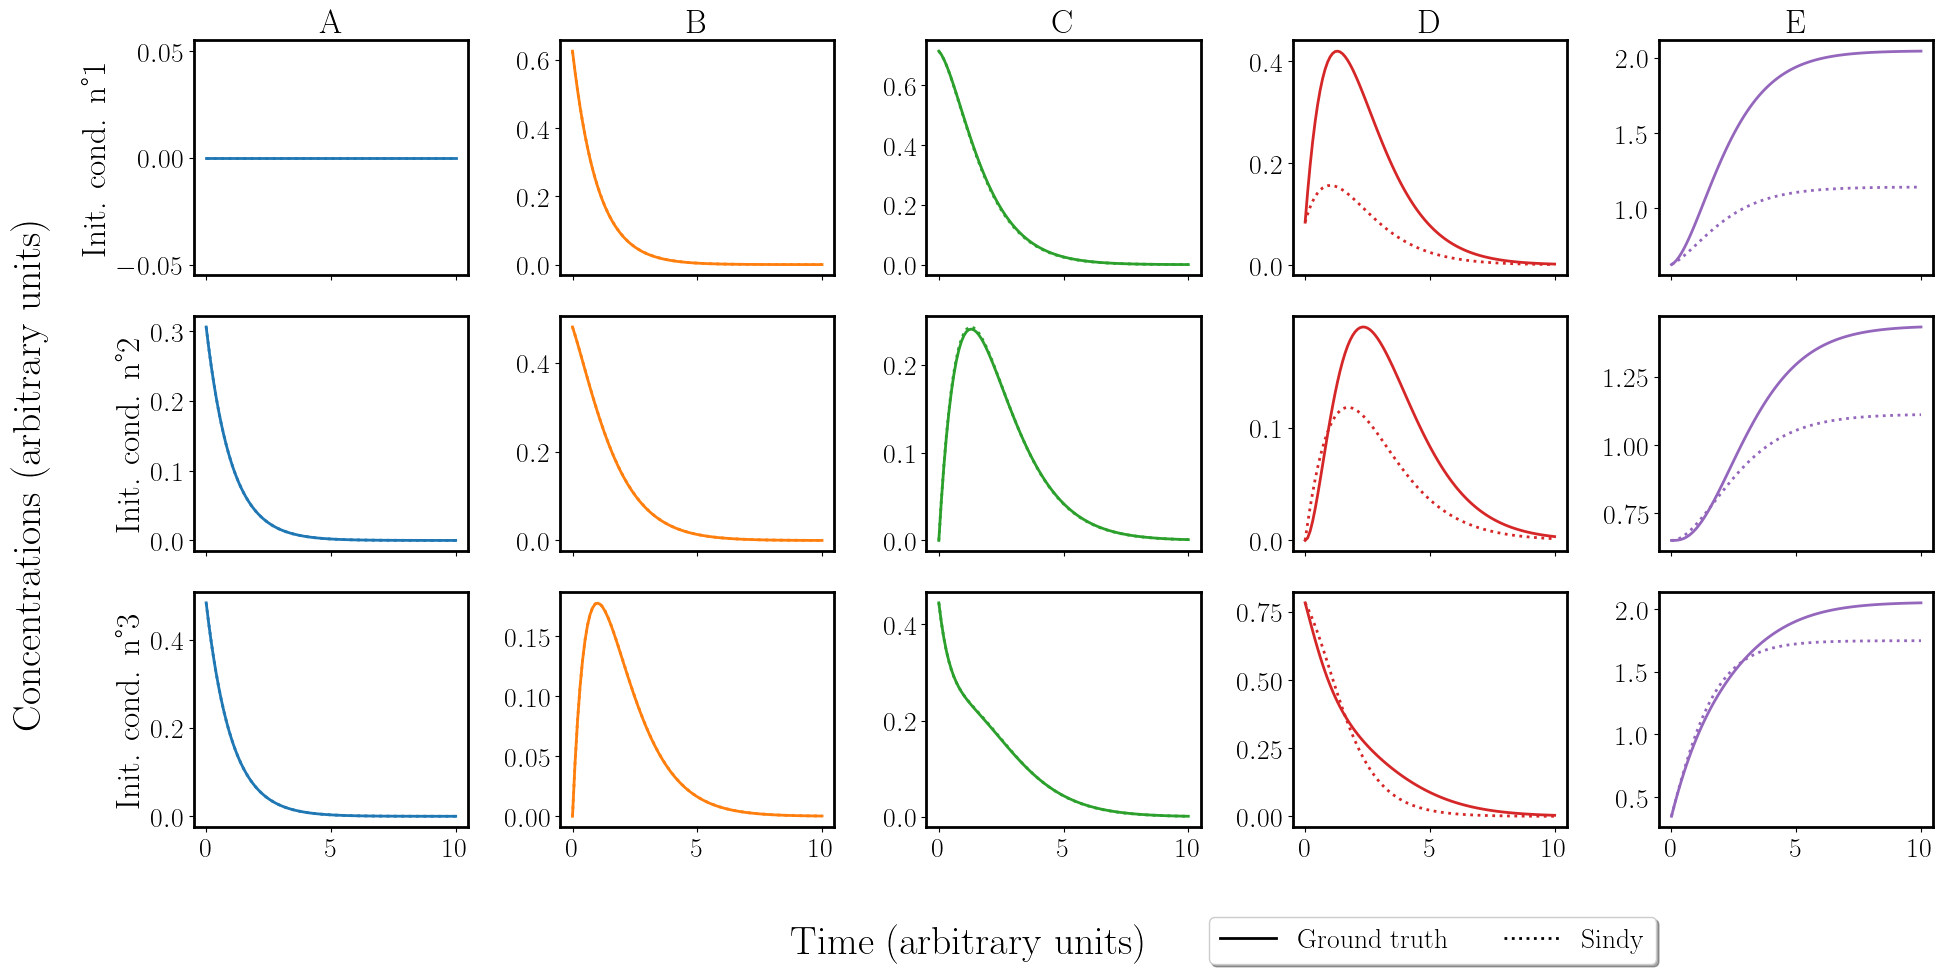

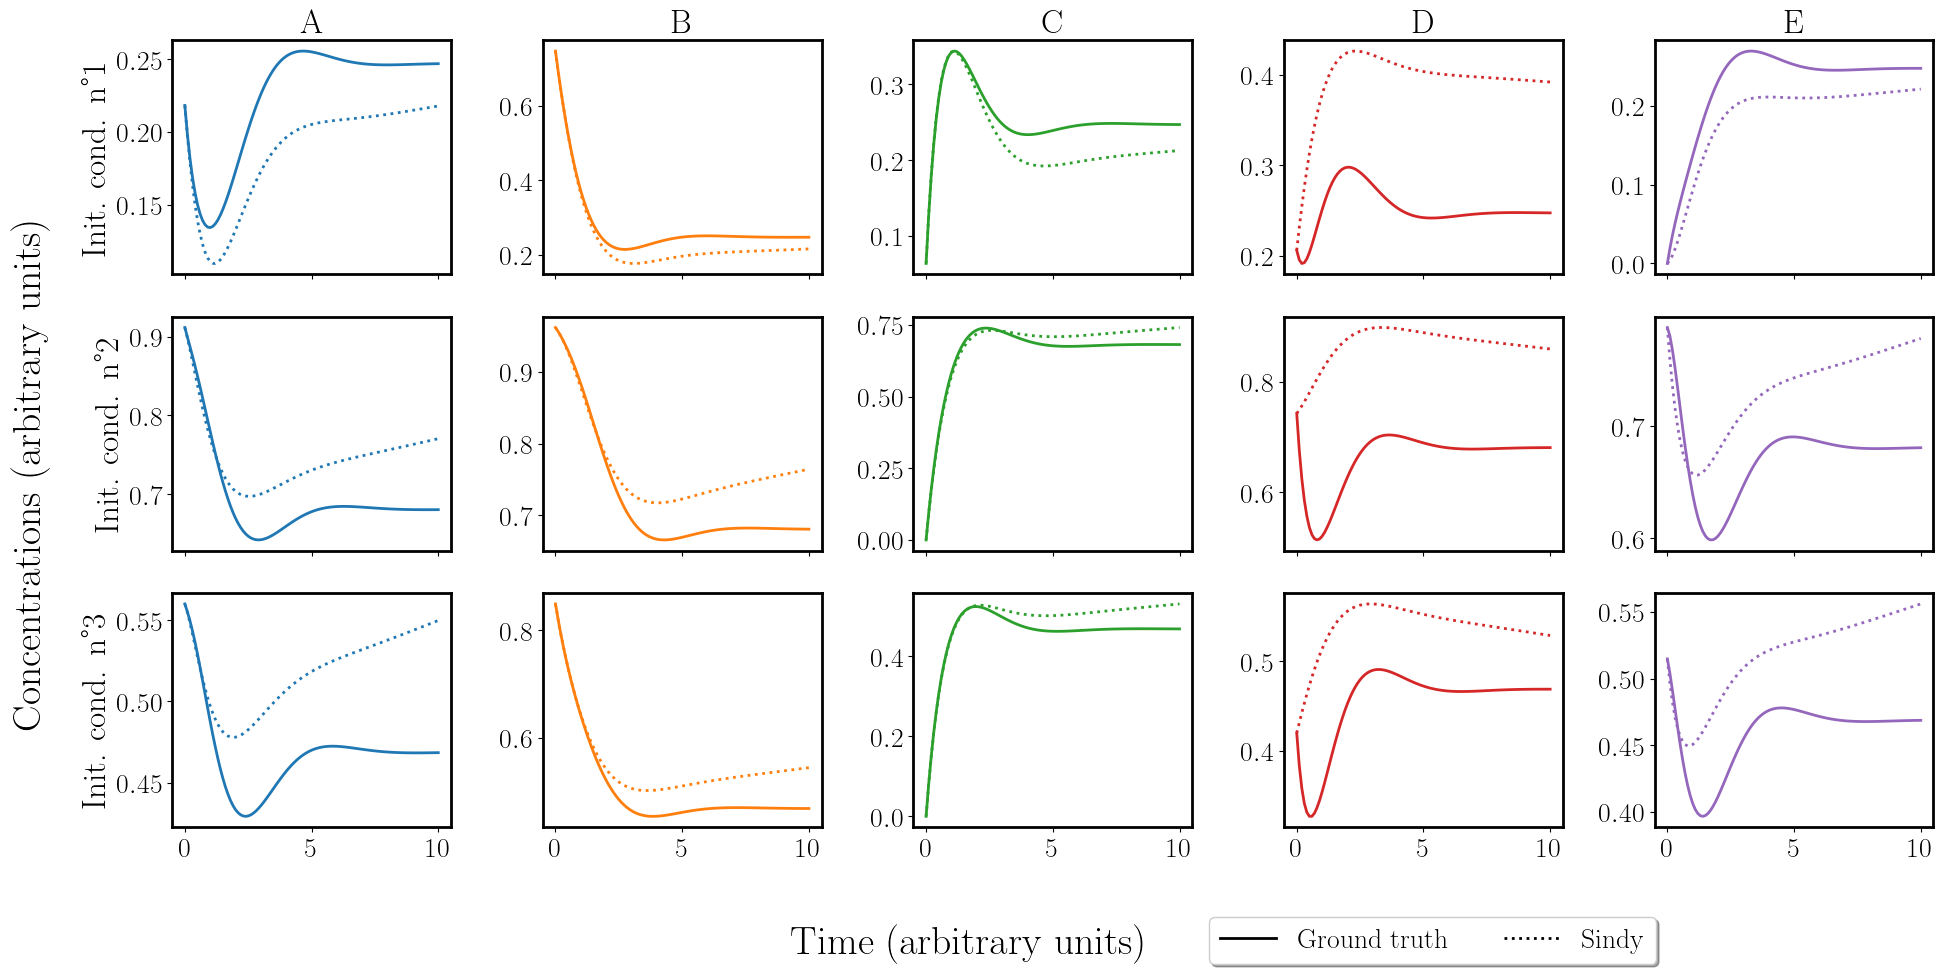

In [11]:
crns =  ["chain", "loop"]
thresh = [.2, .22]

for c in range(len(crns)):
    gt_crn, K, cata, name_species, y0, ode = func_crn_name(crns[c])()
    T, npts = 10, 101
    t = np.linspace(0, T, npts)
    exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))

    Y = np.random.uniform(0, 1, size=(3, exps.shape[1])) * np.random.choice(range(2),
                          size=(3, exps.shape[1]), p=[0.25, .75])

    fig, axes = plt.subplots(3, exps.shape[1], figsize=(20, 10), sharex=True)
    for j in range(len(Y)):
        axes[j, 0].set_ylabel(f"Init. cond. n°{j+1}")
        sindy_res = models[c].simulate(Y[j], t,
                                integrator="solve_ivp",
                                integrator_kws={"method": "LSODA", "atol":10**(-12), "rtol":10**(-12)})
        ground_res = odeint(ode, Y[j], t, atol=10**(-12), rtol=10**(-12))
        for i in range(sindy_res.shape[1]):
            axes[j, i].plot(t, ground_res[:, i], color=f'C{i}')
            axes[j, i].plot(t, sindy_res[:, i], linestyle='dotted', color=f'C{i}')
            axes[0, i].set_title(name_species[i])
    fig.supxlabel('Time (arbitrary units)')
    fig.supylabel('Concentrations (arbitrary units)')
    lines = [Line2D([0], [0], color="black"), Line2D([0], [0], color="black",linestyle='dotted')]
    fig.legend(lines, ["Ground truth", "Sindy"], shadow=True, ncol=2, bbox_to_anchor=(.85, .07))
    fig.tight_layout()
plt.show()

## Sensitivity Analyses

Sensitivity analyses routines are provided in the scripts ```run_all.py```, which calls multiple times ```run_example_fast.py```.